In [ ]:
# Works best with jupyter-notebook

In [1]:
%matplotlib notebook 
#%matplotlib widget 
# https://ipython.readthedocs.io/en/stable/interactive/magics.html
import math
import numpy as np

from spatialmath import *
from spatialmath.base import *

import roboticstoolbox as rtb
from roboticstoolbox import *

import matplotlib.pyplot as plt
np.set_printoptions(linewidth=100, formatter={'float': lambda x: f"{x:8.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})

# Lecture 6.4 Analytic Inverse Kinematics

In this notebook, we will begin to explore the inverse kinematics for a 6DOF 3D robot. 

---

Under the DHRobot class, we have a number of inverse kinemtic methods that we will study:
https://github.com/petercorke/robotics-toolbox-python/wiki/Kinematics
https://petercorke.github.io/robotics-toolbox-python/arm_dh.html

**Analytic method:**
- sol = ikine_a(T, config='lun'): for specific DH robots only

*Note: Wherever possible use analytic methods as they are much faster and more accurate.*

**Numeric method:**
- sol = ikine_LM(T, q0=None): Numerical inverse kinematics by Levenberg-Marquadt optimization (Robot superclass)

- sol = ikine_min(qlim=True) which uses scipy.minimize with user cost function and stiffness. 

--- 

The elements of the tuple sol include at least:


Element   | Type 	      | Description 
:---|:---|:---
q 	      | ndarray (n)   | Joint coordinates for the solution, or None 
:---|:---|:---
success   | bool 	      | True if a solution found 
:---|:---|:---
reason 	  | str 	      | reason for failure 
:---|:---|:---
iterations| int 	      | number of iterations 
:---|:---|:---
residual  | float 	      | final value of cost function 

---

Note that **numerical IK solvers** minimise a *scalar measure of error* between the current and the desired end-effector pose. The measure is the squared-norm of a 6-vector comprising:

- translational error (a 3-vector)
- the orientation error as an Euler vector (angle/axis form encoded as a 3-vector)

The SciPy based mimimizers are **slow** because they use a scalar cost measure and must *numerically compute a Jacobian* in order to solve.


Let's start by creating a model for the Puma560 robot.

In [2]:
puma = rtb.models.DH.Puma560()
print(puma)

┏━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓
┃θⱼ  ┃         dⱼ         ┃   aⱼ   ┃   ⍺ⱼ   ┃   q⁻    ┃   q⁺   ┃
┣━━━━╋━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━╋━━━━━━━━╋━━━━━━━━━╋━━━━━━━━┫
┃ q1 ┃ 0.6718299999999999 ┃      0 ┃  90.0° ┃ -160.0° ┃ 160.0° ┃
┃ q2 ┃                  0 ┃ 0.4318 ┃   0.0° ┃ -110.0° ┃ 110.0° ┃
┃ q3 ┃            0.15005 ┃ 0.0203 ┃ -90.0° ┃ -135.0° ┃ 135.0° ┃
┃ q4 ┃             0.4318 ┃      0 ┃  90.0° ┃ -266.0° ┃ 266.0° ┃
┃ q5 ┃                  0 ┃      0 ┃ -90.0° ┃ -100.0° ┃ 100.0° ┃
┃ q6 ┃                  0 ┃      0 ┃   0.0° ┃ -266.0° ┃ 266.0° ┃
┗━━━━┻━━━━━━━━━━━━━━━━━━━━┻━━━━━━━━┻━━━━━━━━┻━━━━━━━━━┻━━━━━━━━┛

┌─────┬─────┬──────┬───────┬─────┬──────┬─────┐
│name │ q0  │ q1   │ q2    │ q3  │ q4   │ q5  │
├─────┼─────┼──────┼───────┼─────┼──────┼─────┤
│  qz │  0° │  0°  │  0°   │  0° │  0°  │  0° │
│  qr │  0° │  90° │ -90°  │  0° │  0°  │  0° │
│  qs │  0° │  0°  │ -90°  │  0° │  0°  │  0° │
│  qn │  0° │  45° │  180° │  0° │  45° │  0° │
└─────┴─────┴

Plot with joint angles at zero.

<IPython.core.display.Javascript object>


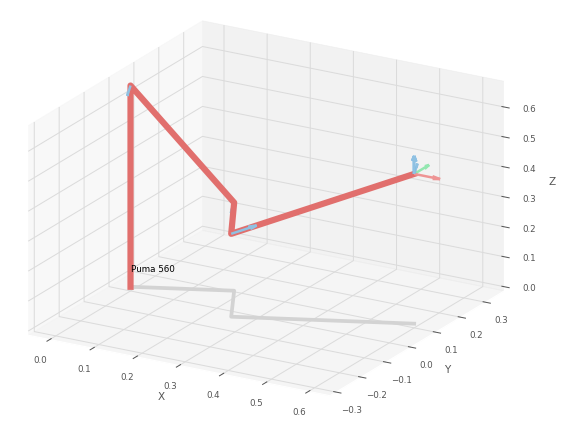

In [3]:
puma.plot(puma.qz);

Let us now designate a desired end-effector pose that we would like the puma robot to reach. 

In [4]:
T = SE3(0.6, 0.1, 0.5)*SE3().RPY([0, 0, 0], unit='deg')

print(type(T))
print(T)

<class 'spatialmath.pose3d.SE3'>
   1           0           0           0.6          
   0           1           0           0.1          
   0           0           1           0.5          
   0           0           0           1            



Plot the desired pose:

<IPython.core.display.Javascript object>


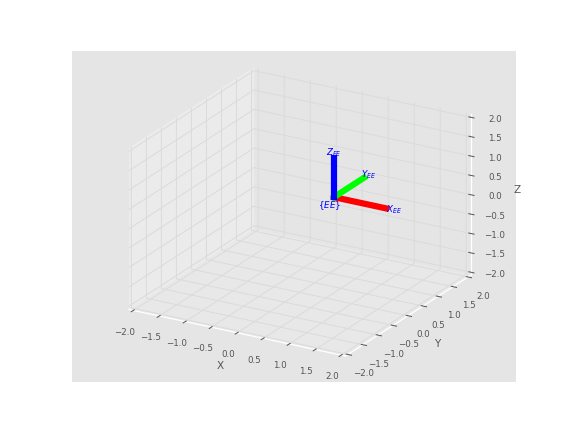

In [5]:
trplot(T.A, dims=[-2,2], frame='EE', rviz=True); # Extracts numpy from T

In [6]:
sol = puma.ikine_a(T)
print(sol)

IKsolution(q=array([   3.057,    2.644,  0.03708,        0,   -2.681,   -3.057]), success=True, reason='')


#### Solutions:

Remember the output is a named tuple with 3 quantities. The first quantitiy is the joing angle solution for the desired pose.

In [7]:
print(type(sol.q))
print(sol.q)

<class 'numpy.ndarray'>
[   3.057    2.644  0.03708        0   -2.681   -3.057]


Now, let's update the puma plot to see if the end-effector matches the pose seen in the trplot above. 

In [8]:
puma.plot(sol.q);

We can also look at the solution with other configurations.\
The defaul is 'lun'. 

Try a right handed configuration and plot. Notice how python let's you call .q on the method. This is the pythonic way to compress code elegantly.

In [13]:
puma.plot( puma.ikine_a(T, config='run').q );

Elbow-down:

In [14]:
puma.plot( puma.ikine_a(T, config='rdn').q );

Flipped-wrist:

In [15]:
puma.plot( puma.ikine_a(T, config='rdf').q );